# Leopard Segmentation using Local Binary Patterns (LBP)

This project demonstrates **texture-based image segmentation** using Local Binary Patterns to identify and extract a leopard from its background.

## Project Overview

The goal is to segment a leopard from an image by analyzing texture patterns. The approach uses:
- **Local Binary Patterns (LBP)**: A texture descriptor that encodes local texture information
- **Patch-based Learning**: Sample patches from leopard fur and background areas
- **KL Divergence**: Measure similarity between texture histograms
- **Sliding Window**: Scan the entire image to classify each region
- **Morphological Operations**: Clean up and refine the segmentation mask

## Workflow

1. Install required dependencies (scikit-image)
2. Load and display the leopard image
3. Extract sample patches from leopard and non-leopard regions
4. Compute LBP histograms for each patch
5. Use sliding window to classify all image regions
6. Apply morphological operations to refine the mask
7. Display segmentation results

In [ ]:
!conda install scikit-image -c conda-forge -y

## Step 1: Load and Visualize the Image

Display the input leopard image that we'll be segmenting.

![Leopard Image](leopard.jpg)

## Step 2: Import Libraries

Import the necessary libraries for image processing and texture analysis.

In [1]:
from skimage.feature import local_binary_pattern
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Step 3: Extract Training Patches

Load the image and extract sample patches from:
- **Leopard regions**: Areas with spotted/textured fur (3 patches)
- **Non-leopard regions**: Background areas (3 patches)

These patches serve as training examples to learn what leopard texture looks like versus background texture.

The patches are visualized to verify they capture the appropriate textures.

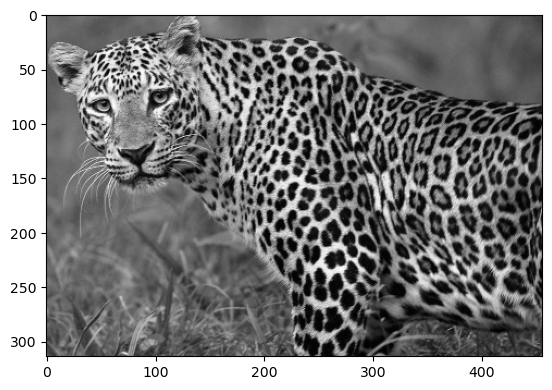

<Figure size 640x480 with 0 Axes>

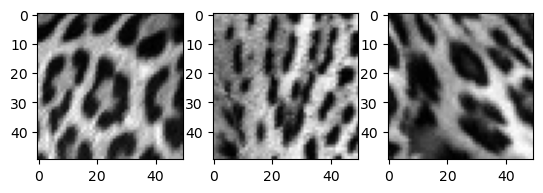

<Figure size 640x480 with 0 Axes>

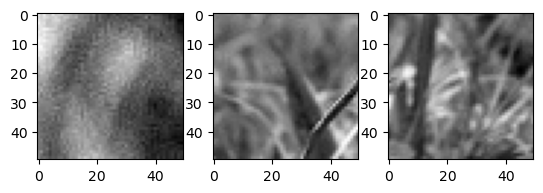

In [2]:
leopardImage = cv2.imread('leopard.jpg', cv2.IMREAD_GRAYSCALE)
leopardImage = cv2.resize(leopardImage, None,fx=0.5,fy=0.5) #resize to reduce computation time

# Just sample patches, you can change to any position you want
leopardPatch1 = leopardImage[100:150,400:450]
leopardPatch2 = leopardImage[100:150,150:200]
leopardPatch3 = leopardImage[200:250,300:350]

nonleopardPatch1 = leopardImage[0:50,400:450]
nonleopardPatch2 = leopardImage[250:300,0:50]
nonleopardPatch3 = leopardImage[250:300,100:150]


plt.figure()
plt.imshow(leopardImage, cmap='gray')

plt.figure()
_, axarr = plt.subplots(1,3)
axarr[0].imshow(leopardPatch1, cmap='gray')
axarr[1].imshow(leopardPatch2, cmap='gray')
axarr[2].imshow(leopardPatch3, cmap='gray')

plt.figure()
_, axarr = plt.subplots(1,3)
axarr[0].imshow(nonleopardPatch1, cmap='gray')
axarr[1].imshow(nonleopardPatch2, cmap='gray')
axarr[2].imshow(nonleopardPatch3, cmap='gray')

## Step 4: LBP-Based Segmentation

### Algorithm Steps:

1. **Compute LBP Histograms**: Extract texture features from all patches using Local Binary Pattern with parameters P=8, R=1
   
2. **Sliding Window Classification**: 
   - Scan the image with a 50x50 pixel window
   - For each window, compute its LBP histogram
   - Calculate KL divergence to measure similarity with leopard and non-leopard patches
   - Classify as leopard if it's more similar to leopard patches

3. **Morphological Refinement**:
   - **Closing**: Fill small gaps in the detected leopard region
   - **Opening**: Remove small noise pixels
   - **Contour Filtering**: Keep only the largest connected component (the leopard body)

4. **Visualization**: Display intermediate results and final segmentation

### Key Parameters:
- `win_size = 50`: Size of sliding window
- `step = 10`: Window stride for scanning
- `P = 8, R = 1`: LBP parameters (8 neighbors at radius 1)
- Threshold: `0.006` for leopard similarity detection

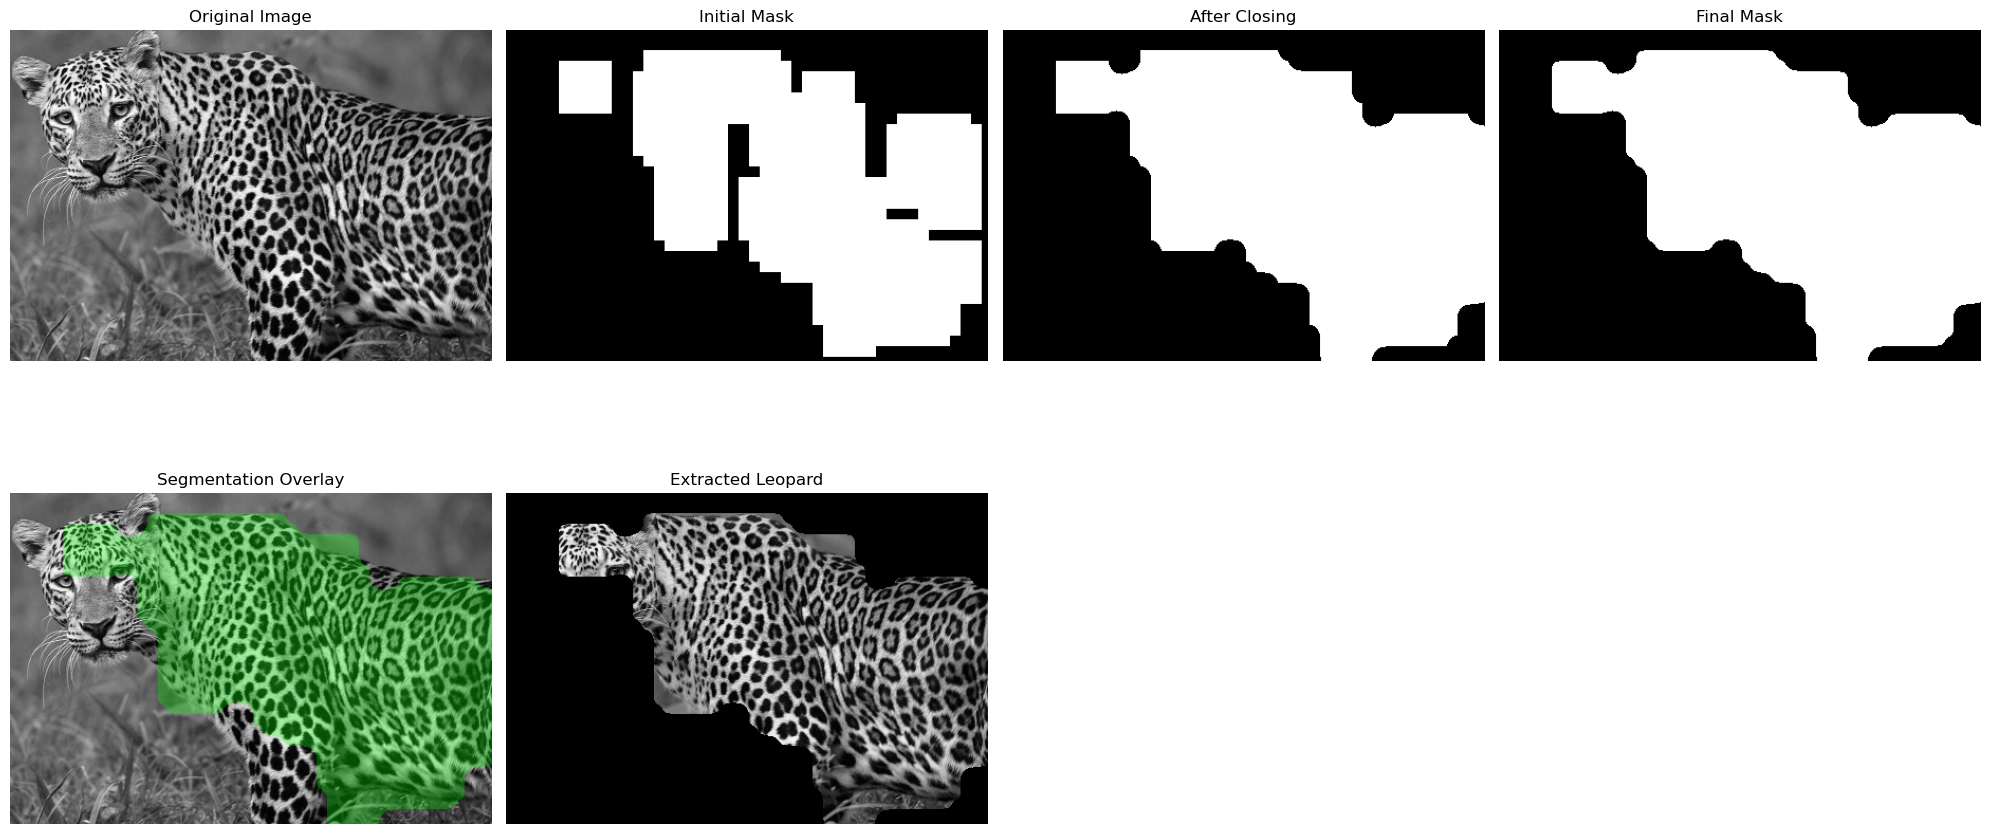

Number of contours found: 1
Largest contour area: 70978 pixels


In [3]:
# Use moderate P and R values
P = 8
R = 1

def kldivergence(p, q):
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

def get_lbp_hist(patch):
    lbp = local_binary_pattern(patch, P, R, method='uniform')
    nBin = int(lbp.max()) + 1
    hist, _ = np.histogram(lbp, bins= nBin, range = (0, nBin), density=True)
    return hist

# Get histograms for leopard patches
leopard_hist1 = get_lbp_hist(leopardPatch1)
leopard_hist2 = get_lbp_hist(leopardPatch2)
leopard_hist3 = get_lbp_hist(leopardPatch3)
leopard_hists = [leopard_hist1, leopard_hist2, leopard_hist3]

# Get histograms for non-leopard patches (background)
nonleopard_hist1 = get_lbp_hist(nonleopardPatch1)
nonleopard_hist2 = get_lbp_hist(nonleopardPatch2)
nonleopard_hist3 = get_lbp_hist(nonleopardPatch3)
nonleopard_hists = [nonleopard_hist1, nonleopard_hist2, nonleopard_hist3]

# Sliding window
win_size = 50
step = 10  # Smaller step for better coverage

mask = np.zeros(leopardImage.shape, dtype=np.uint8)
for y in range(0, leopardImage.shape[0] - win_size, step):
    for x in range(0, leopardImage.shape[1] - win_size, step):
        window = leopardImage[y:y+win_size, x:x+win_size]
        window_hist = get_lbp_hist(window)
        
        # Distance to leopard patches
        leopard_dists = [kldivergence(window_hist, h) for h in leopard_hists]
        min_leopard_dist = np.min(leopard_dists)
        
        # Distance to background patches
        nonleopard_dists = [kldivergence(window_hist, h) for h in nonleopard_hists]
        min_nonleopard_dist = np.min(nonleopard_dists)
        
        # More relaxed thresholds
        if min_leopard_dist < 0.006 and min_leopard_dist < min_nonleopard_dist * 0.8:
            mask[y:y+win_size, x:x+win_size] = 255

# Apply morphological operations to clean up the mask
# 1. Close small gaps
kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (25, 25))
mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)

# 2. Remove small noise
kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
mask_opened = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel_open)

# 3. Keep only the largest contour (the leopard)
contours, _ = cv2.findContours(mask_opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours:
    largest_contour = max(contours, key=cv2.contourArea)
    mask_final = np.zeros_like(mask_opened)
    cv2.drawContours(mask_final, [largest_contour], -1, 255, -1)
else:
    mask_final = mask_opened

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(2, 4, 1)
plt.imshow(leopardImage, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(mask, cmap='gray')
plt.title('Initial Mask')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(mask_closed, cmap='gray')
plt.title('After Closing')
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(mask_final, cmap='gray')
plt.title('Final Mask')
plt.axis('off')

# Overlay result on original image
overlay = cv2.cvtColor(leopardImage, cv2.COLOR_GRAY2RGB)
overlay[mask_final > 0] = [0, 255, 0]
result = cv2.addWeighted(cv2.cvtColor(leopardImage, cv2.COLOR_GRAY2RGB), 0.7, overlay, 0.3, 0)

plt.subplot(2, 4, 5)
plt.imshow(result)
plt.title('Segmentation Overlay')
plt.axis('off')

# Show segmented leopard only
segmented_leopard = cv2.cvtColor(leopardImage, cv2.COLOR_GRAY2RGB)
segmented_leopard[mask_final == 0] = [0, 0, 0]
plt.subplot(2, 4, 6)
plt.imshow(segmented_leopard)
plt.title('Extracted Leopard')
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Number of contours found: {len(contours)}")
if contours:
    print(f"Largest contour area: {cv2.contourArea(largest_contour):.0f} pixels")